# Q-SITE 2024: IBM Quantum Hackathon

## Lab 3: Utility-scale Circuits

In this lab, you will explore how to create large circuits that use over 100 qubits. This lab is inspired by a research paper published by IBM in June 2023 entitled ***Evidence for the utility of quantum computing before fault tolerance*** in the journal Nature (see paper [here](https://www.nature.com/articles/s41586-023-06096-3)). In the paper, researchers demonstrated meaningful computations of a real physics problem using over 100 qubits with high fidelity results. At this scale, the computations were beyond the capability of classical computers to perform the same computation using brute-force classical algorithms. This is what we refer to as **utility-scale quantum computing**. Programmers need to be mindful of the topology of the quantum processor in order to implement circuits that are both efficient and that will produce high fidelity results. The paper's authors took this into account in their computations. They also used techniques that were able to overcome noise and errors in the system using a combination of error suppression and error mitigation methods.

The code required to complete the exercise should be typed under the line which has the ```## WRITE YOUR CODE BELOW HERE ##``` comment. Avoid making changes to any provided code as this could alter how other code in the notebook functions. You will submit answers to the grader methods that are called in this notebook. This lab has 5 graded exercises.

### Background

The paper ***Evidence for the utility of quantum computing before fault tolerance*** considered a physics problem on the dynamics of a lattice of particles with a "spin" property. The spins of the system are influenced by a global transerve field. Mathematically, the system is described by the following Hamiltonian operator:

$H = -J \sum_{i,j}{Z_i Z_j} + h \sum_i X_i$

where $J$ is the coupling coefficient of nearest neighbour spins, $h$ is the global transverse field coefficient, and $Z$ and $X$ are the Pauli Z and Pauli X operator, respectively. Spin dynamics can be simulated over time using a technique known as Trotterization, which breaks up the computation into short time steps.

The particles in the lattice can be arranged in a multitude of ways. In the simplest case, the spins can be a one-dimensional chain with each spin interacting with up to two nearest-neighbours. For the paper, the authors considered a two-dimensional lattice arranged in a heavy-hexagonal pattern, with each spin interacting with up to 3 nearest-neighbours. 

In [1]:
from qiskit import QuantumCircuit, transpile
from qiskit.primitives import StatevectorSampler
from qiskit.visualization import plot_circuit_layout
import numpy as np

In [2]:
from grader.qsite24_ibm_grader import *

### Part 1: 1-D chain

In this first part of the lab, let's work with the simple case of a one-dimensional spin chain. You'll work your way from the up to the two-dimensional case later on in the lab.

#### Exercise 1a: Constructing a custom gate

The first exercise will be to create a two-qubit circuit that represents the implementation of a high-level gate used in the paper: the $R_{ZZ}(\theta)$ gate. This gate is used to simulate the $Z_i Z_j$ terms in the Hamiltonian equation above. There is an implementation of this gate in Qiskit (see [here](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.RZZGate)). The parameter $\theta$ represents a rotation angle. The generic $R_{ZZ}(\theta)$ gate can be implemented with more common gates in a number of ways. In the paper, the authors considered the specific angle $\theta = -\pi/2$. In this case, the $R_{ZZ}(-\pi/2)$ gate can be implemented as follows:

![RZZ circuit](https://media.springernature.com/lw265/springer-static/image/art%3A10.1038%2Fs41586-023-06096-3/MediaObjects/41586_2023_6096_Figa_HTML.png)

**YOUR TASK**: implement the $R_{ZZ}(-\pi/2)$ as a two-qubit quantum circuit. Note that the circuit above uses a couple of gates that you may not have used previously:
- **$S^\dag$**: the S-adjoint gate. It induces a $-\pi/2$ phase shift on a qubit by rotating it about the Z-axis. This gate is similar to the $S$ gate, which induces at $+\pi/2$ phase shift. The $\dag$ symbol on the gate signifies that the gate is the "adjoint" version of the gate, which in this case means a negative phase shift instead of a positive one. See [here](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.SdgGate) on how to use this gate in Qiskit.
- **$\sqrt{Y}$ (and $\sqrt{Y}^\dag$)**: the square root Y gate (and it's adjoint). This rotates a qubit about it's Y-axis by $\pi/2$. It's similar to the $\sqrt{X}$ gate that you may have noticed in transpiled circuits, except that it involves the Y-axis instead of the X-axis. Qiskit does not have a ready-made $\sqrt{Y}$ gate available. You'll need to find an alternative using one of the standard gates available in Qiskit (see [here](https://docs.quantum.ibm.com/api/qiskit/circuit_library#standard-gates)).

In [3]:
qc_rzz = QuantumCircuit(2)

## WRITE YOUR CODE BELOW HERE ##
qc_rzz.sdg([0,1])
qc_rzz.ry(np.pi/2,1)
qc_rzz.cx(0,1)
qc_rzz.ry(-np.pi/2,1)

In [4]:
# SUBMIT CIRCUIT TO GRADER
qsite24_grader_lab3ex1a(qc_rzz)

Congratulations! 🎉 Your answer is correct.


It can help streamline creating more complex circuits involving the $R_{ZZ}(-\pi/2)$ gate by turning the two-qubit circuit you created above into a custom gate. To do this, use the ```to_gate()``` method as shown below.

In [5]:
RZZp2Gate = qc_rzz.to_gate(label="RZZ(-π/2)")

#### A simple circuit implementation

Now let's use this gate to construct a straightforward circuit that implements a single time-step simulation of the Hamiltonian of the spin model. The code below creates a circuit with 10 qubits and applies our $R_{ZZ}$ gate sequentially to each pair of those qubits. To use our custom gate, the code uses the ```append()``` method of the ```QuantumCircuit``` object to add the gate to the circuit with specific qubit pairs.

In [7]:
n_qubits = 10
qc_sequential = QuantumCircuit(n_qubits)

for i in range(n_qubits-1):
    qc_sequential.append(RZZp2Gate, [i, i+1])

qc_sequential.draw(fold=-1)

┌────────────┐                                                                                                                
q_0: ┤0           ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     │  RZZ(-π/2) │┌────────────┐                                                                                                  
q_1: ┤1           ├┤0           ├──────────────────────────────────────────────────────────────────────────────────────────────────
     └────────────┘│  RZZ(-π/2) │┌────────────┐                                                                                    
q_2: ──────────────┤1           ├┤0           ├────────────────────────────────────────────────────────────────────────────────────
                   └────────────┘│  RZZ(-π/2) │┌────────────┐                                                                      
q_3: ────────────────────────────┤1           ├┤0           ├──────────────────────────────────────────────────────────────────────
                                 └────────────┘│  RZZ(-π/2) │┌────────────┐                                                        
q_4: ──────────────────────────────────────────┤1           ├┤0           ├────────────────────────────────────────────────────────
                                               └────────────┘│  RZZ(-π/2) │┌────────────┐                                          
q_5: ────────────────────────────────────────────────────────┤1           ├┤0           ├──────────────────────────────────────────
                                                             └────────────┘│  RZZ(-π/2) │┌────────────┐                            
q_6: ──────────────────────────────────────────────────────────────────────┤1           ├┤0           ├────────────────────────────
                                                                           └────────────┘│  RZZ(-π/2) │┌────────────┐              
q_7: ────────────────────────────────────────────────────────────────────────────────────┤1           ├┤0           ├──────────────
                                                                                         └────────────┘│  RZZ(-π/2) │┌────────────┐
q_8: ──────────────────────────────────────────────────────────────────────────────────────────────────┤1           ├┤0           ├
                                                                                                       └────────────┘│  RZZ(-π/2) │
q_9: ────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤1           ├
                                                                                                                     └────────────┘

As you can see in the above circuit diagram, the gates are applied one after another in a staircase pattern. While this will implement the needed simulation, it does not use the qubits very efficiently. You should notice that 1) there is a lot of idle time on each of the qubits when gates are not being applied to them, and 2) the depth of the circuit, i.e. the number of gates that must be executed sequentially, is somewhat large. We can calculate the gate depth of this circuit in terms of the number of sequential two-qubits gates that need to be executed. Since two-qubit gates, such as CNOT, tend to be the longest duration and the most error-prone gates on real hardware, the two-qubit gate depth of a circuit is a good indication of well the circuit will perform. A shorter depth is preferred.

In [8]:
# Compute depth of 2-qubit gates
def get_2q_gate_depth(qc):
    return qc.depth(lambda x: len(x.qubits) == 2)

print("Two-qubit depth:", get_2q_gate_depth(qc_sequential))

Two-qubit depth: 9


A two-qubit depth of 9 as is the case for this circuit is not too bad. However, you surely have realized that if you were to scale this circuit to more qubits, the depth will increase as well. For 127 qubits, the depth would be 126 for a single time step in the simulation! With near-term hardware, a circuit of that depth will likely not produce good results since noise would take over.

#### Exercise 1b: A layered approach

Let's see if we can improve the depth of the circuit. You can leverage the capability of the hardware to execute multiple gates simulataneously on different sets of qubits. For example, if you have a CNOT gate involving qubits 0 and 1, and another CNOT gate involving qubits 2 and 3, those gates can be executed at the same time. However, you could not execute a CNOT gate involving qubits 0 and 1 at the same time as a CNOT gate involving qubits 1 and 2 (those would need to be executed one after the other).

In the case of the spin model being simulated in this lab, we can rearrange the two-qubit gates such that we can execute many of them in parallel. The model requires that we implement the $R_{ZZ}$ between every pair of neighbouring qubits, so we can't do all of the two-qubits gates in parallel. Instead, we can build multiple layers of two-qubit gates in order to implement all of the needed interactions between neighbouring pairs of qubits.

**YOUR TASK**: Build a layered circuit with 10 qubits where multiple $R_{ZZ}$ gate can execute in parallel. Your circuit should have two layers of $R_{ZZ}$ gates, and thus should have a two-qubit gate depth of two.

**TIP**: It is suggested that you create a function that can generate a layered circuit with any number of qubits. You'll need to generate a similar circuit later on in the lab with more qubits.

In [12]:
n_qubits = 10
qc_layered = QuantumCircuit(n_qubits)

## WRITE YOUR CODE BELOW HERE ##
def layer_rzz(qc):
    for i in range(0,qc.num_qubits,2):
        qc.append(RZZp2Gate,[i,i+1])
    for i in range(1,qc.num_qubits-1,2):
        qc.append(RZZp2Gate,[i,i+1])

layer_rzz(qc_layered)
qc_layered.draw(fold=-1)

┌────────────┐              
q_0: ┤0           ├──────────────
     │  RZZ(-π/2) │┌────────────┐
q_1: ┤1           ├┤0           ├
     ├────────────┤│  RZZ(-π/2) │
q_2: ┤0           ├┤1           ├
     │  RZZ(-π/2) │├────────────┤
q_3: ┤1           ├┤0           ├
     ├────────────┤│  RZZ(-π/2) │
q_4: ┤0           ├┤1           ├
     │  RZZ(-π/2) │├────────────┤
q_5: ┤1           ├┤0           ├
     ├────────────┤│  RZZ(-π/2) │
q_6: ┤0           ├┤1           ├
     │  RZZ(-π/2) │├────────────┤
q_7: ┤1           ├┤0           ├
     ├────────────┤│  RZZ(-π/2) │
q_8: ┤0           ├┤1           ├
     │  RZZ(-π/2) │└────────────┘
q_9: ┤1           ├──────────────
     └────────────┘

In [11]:
# SUBMIT CIRCUIT TO GRADER
qsite24_grader_lab3ex1b(qc_layered)

Congratulations! 🎉 Your answer is correct.


#### Transpiling for a real backend

Now that you have a layered circuit, let's transpile it for a hardware backend and see the result. In the code below, we choose one of the 127-qubit Eagle processors from IBM (in this case, ```ibm_brisbane```, but you can choose another one if you like)

In [15]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(channel='ibm_quantum')
backend = service.backend('ibm_brisbane')

The code below will carry out the transpilation. The optimization level is set to 1 initially, but you can experiment with setting this to 2 or 3 and see what happens.

In [18]:
qc_layered_t = transpile(qc_layered, backend, optimization_level=1)
qc_layered_t.draw(idle_wires=False, fold=-1)

global phase: 5π/4
         ┌──────────┐┌────┐┌──────────┐┌──────┐┌──────────┐ ┌────┐ ┌─────────┐                                       
q_0 -> 0 ┤ Rz(-π/2) ├┤ √X ├┤ Rz(-π/2) ├┤1     ├┤ Rz(-π/2) ├─┤ √X ├─┤ Rz(π/2) ├───────────────────────────────────────
         └──┬───┬───┘└────┘└──────────┘│  Ecr │├─────────┬┘ ├────┤ ├─────────┴┐┌──────┐┌──────────┐┌────┐┌─────────┐ 
q_1 -> 1 ───┤ X ├──────────────────────┤0     ├┤ Rz(π/2) ├──┤ √X ├─┤ Rz(-π/2) ├┤1     ├┤ Rz(-π/2) ├┤ √X ├┤ Rz(π/2) ├─
         ┌──┴───┴───┐┌────┐┌──────────┐├──────┤├─────────┤  ├────┤ ├─────────┬┘│  Ecr │└┬────────┬┘└────┘└─────────┘ 
q_2 -> 2 ┤ Rz(-π/2) ├┤ √X ├┤ Rz(-π/2) ├┤1     ├┤ Rz(π/2) ├──┤ √X ├─┤ Rz(π/2) ├─┤0     ├─┤ Rz(-π) ├───────────────────
         └──┬───┬───┘└────┘└──────────┘│  Ecr │├─────────┤  ├────┤ ├─────────┴┐├──────┤┌┴────────┴┐┌────┐┌─────────┐ 
q_3 -> 3 ───┤ X ├──────────────────────┤0     ├┤ Rz(π/2) ├──┤ √X ├─┤ Rz(-π/2) ├┤1     ├┤ Rz(-π/2) ├┤ √X ├┤ Rz(π/2) ├─
          ┌─┴───┴──┐                   ├──────┤└─────────┘  └────┘ └──────────┘│  Ecr │└┬────────┬┘└────┘└─────────┘ 
q_4 -> 4 ─┤ Rz(-π) ├───────────────────┤0     ├────────────────────────────────┤0     ├─┤ Rz(-π) ├───────────────────
         ┌┴────────┤ ┌────┐┌─────────┐ │  Ecr │ ┌────────┐ ┌──────┐┌──────────┐└┬────┬┘┌┴────────┤                   
q_5 -> 5 ┤ Rz(π/2) ├─┤ √X ├┤ Rz(π/2) ├─┤1     ├─┤ Rz(-π) ├─┤1     ├┤ Rz(-π/2) ├─┤ √X ├─┤ Rz(π/2) ├───────────────────
         └┬────────┤ └────┘└─────────┘ ├──────┤ └────────┘ │  Ecr │└┬────────┬┘ └────┘ └─────────┘                   
q_6 -> 6 ─┤ Rz(-π) ├───────────────────┤0     ├────────────┤0     ├─┤ Rz(-π) ├───────────────────────────────────────
         ┌┴────────┤ ┌────┐┌─────────┐ │  Ecr │┌─────────┐ └┬────┬┘┌┴────────┤ ┌──────┐   ┌───┐                      
q_7 -> 7 ┤ Rz(π/2) ├─┤ √X ├┤ Rz(π/2) ├─┤1     ├┤ Rz(π/2) ├──┤ √X ├─┤ Rz(π/2) ├─┤0     ├───┤ X ├──────────────────────
         └┬────────┤ └────┘└─────────┘ ├──────┤├─────────┤  ├────┤ ├─────────┴┐│  Ecr │┌──┴───┴──┐ ┌────┐┌──────────┐
q_8 -> 8 ─┤ Rz(-π) ├───────────────────┤0     ├┤ Rz(π/2) ├──┤ √X ├─┤ Rz(-π/2) ├┤1     ├┤ Rz(π/2) ├─┤ √X ├┤ Rz(-π/2) ├
         ┌┴────────┤ ┌────┐┌─────────┐ │  Ecr │├─────────┤  ├────┤ ├──────────┤└──────┘└─────────┘ └────┘└──────────┘
q_9 -> 9 ┤ Rz(π/2) ├─┤ √X ├┤ Rz(π/2) ├─┤1     ├┤ Rz(π/2) ├──┤ √X ├─┤ Rz(-π/2) ├──────────────────────────────────────
         └─────────┘ └────┘└─────────┘ └──────┘└─────────┘  └────┘ └──────────┘

You can plot out how the transpiler mapped the qubits in your circuit to the physical qubits on the quantum processor. Depending on several factors, including the optimization level, the transpiler may choose a different set of physical qubits onto which to map your circuit.

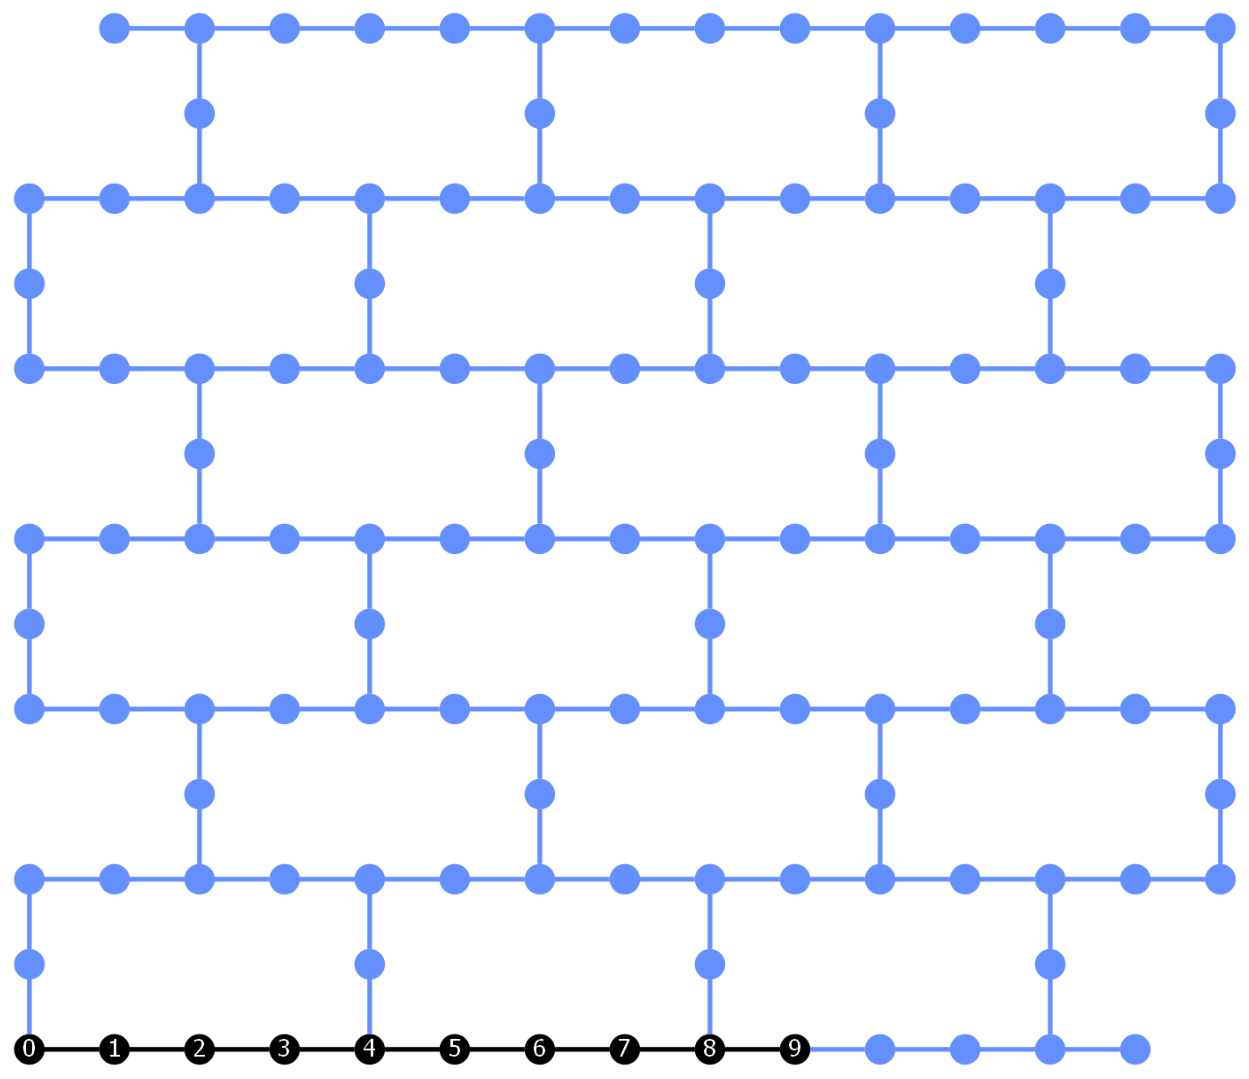

In [17]:
plot_circuit_layout(qc_layered_t, backend)

#### A larger 1-D lattice

Let's now try a slightly larger spin chain of 16 qubits. For this, we'll build a circuit for a smaller 16-qubit quantum processor: ```ibm_guadalupe```. This system is no longer operating (IBM only operates systems with over 100 qubits now), but it is instructive to see what happens when we push the limits on the number of qubits in a processor. The Qiskit Runtime package includes "fake" backends that model IBM's quantum processors, both past and present. You can use these backends to simulate the processor on your classical computer. For this part of the lab, we'll use the ```FakeGuadalupeV2``` fake backend. You'll see the topology of the processor by executing the code in the next notebook cell.

NOTE: Use the "V2" version of the FakeGuadalupe backend. While there is a class called ```FakeGuadalupe```, this is an older version lacking some features, and it will be removed in an upcoming release of Qiskit Runtime.

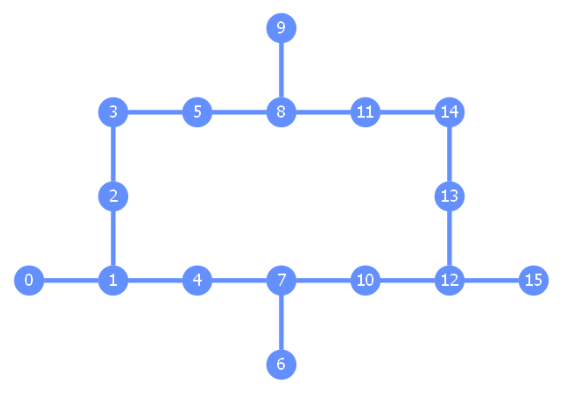

In [19]:
from qiskit_ibm_runtime.fake_provider import FakeGuadalupeV2
from qiskit.visualization import plot_gate_map

fake_backend = FakeGuadalupeV2()
plot_gate_map(fake_backend, figsize=(7, 7), font_size=14)

In the cell below, create a 16-qubit version of the 1-D chain 2-layer circuit that you created previously. The given code will transpile the circuit for the ```FakeGuadalupeV2``` backend, then draw the layout of the circuit onto the qubits of the backend.

(TIP: did you notice our tip from above about creating a Python function that generates such circuits?)

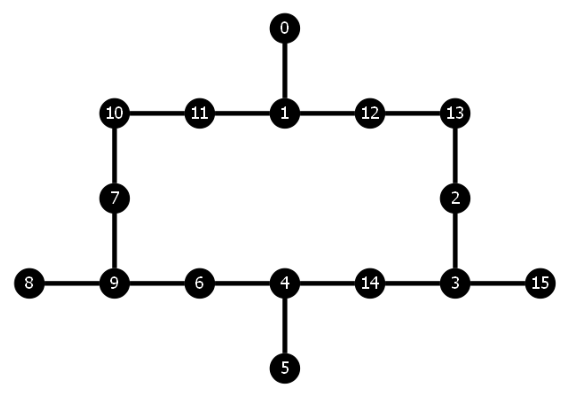

In [20]:
n_qubits = 16

## WRITE YOUR CODE BELOW HERE ##

qc_layered2 = QuantumCircuit(n_qubits,n_qubits)            # Use this variable for your circuit
layer_rzz(qc_layered2)

## DO NOT MODIFY THE LINES BELOW

qc_layered2_t = transpile(qc_layered2, fake_backend, optimization_level=3)

plot_circuit_layout(qc_layered2_t, fake_backend)

Now, calculate the 2-qubit depth of the circuit by running the cell below.

In [21]:
get_2q_gate_depth(qc_layered2_t)

9

What happened? You'll likely notice that the transpiled circuit has a depth larger than 2. Let's see the transpiled circuit itself to investigate.

In [23]:
qc_layered2_t.draw(fold=-1)

┌───────────┐                         ┌────┐  ┌─────────┐                                                                                                                      ┌───┐ ┌─────────┐ ┌────┐┌──────────┐                                                                  
  q_8 -> 0 ┤ Rz(-3π/2) ├───────────────────■─────┤ √X ├──┤ Rz(π/2) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ X ├─┤ Rz(π/2) ├─┤ √X ├┤ Rz(-π/2) ├──────────────────────────────────────────────────────────────────
           └─┬────────┬┘┌────┐┌─────────┐┌─┴─┐┌──┴────┴─┐└──┬────┬─┘┌──────────┐            ┌───┐      ┌────────┐    ┌────┐    ┌─────────┐    ┌───┐    ┌─────────┐   ┌────┐    ┌────────┐ └─┬─┘ └─────────┘ └────┘└──────────┘                                                                  
  q_9 -> 1 ──┤ Rz(-π) ├─┤ √X ├┤ Rz(π/2) ├┤ X ├┤ Rz(π/2) ├───┤ √X ├──┤ Rz(-π/2) ├─────■──────┤ X ├──■───┤ Rz(-π) ├────┤ √X ├────┤ Rz(π/2) ├────┤ X ├────┤ Rz(π/2) ├───┤ √X ├────┤ Rz(-π) ├───■───────────────────────────────────────────────────────────────────────────────────────────────────
             └────────┘ └────┘└─────────┘└───┘└─────────┘   └────┘  └──────────┘   ┌─┴─┐    └─┬─┘┌─┴─┐┌┴────────┴┐   └────┘    └─────────┘    └─┬─┘    └─────────┘   └────┘    └────────┘                                                                                                       
  q_7 -> 2 ────────────────────────────────────────────────────────────────────────┤ X ├──────■──┤ X ├┤ Rz(-π/2) ├─────■────────────────────────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
           ┌───────────┐                         ┌────┐  ┌─────────┐               └───┘         └───┘└──────────┘   ┌─┴─┐     ┌─────────┐      │         ┌────┐  ┌──────────┐                                                                                                                  
 q_10 -> 3 ┤ Rz(-3π/2) ├───────────────────■─────┤ √X ├──┤ Rz(π/2) ├─────────────────────────────────────────────────┤ X ├─────┤ Rz(π/2) ├──────┼─────────┤ √X ├──┤ Rz(-π/2) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────
           └┬──────────┤                   │     └────┘  └─────────┘                                                 └───┘     └─────────┘      │         └────┘  └──────────┘                                       ┌───┐                                                                      
  q_6 -> 4 ─┤ Rz(-π/2) ├───────────────────┼────────────────────────────────────────────────────────────────────────────────────────────────────■─────────────────────────────────────────────────────────────■──────┤ X ├──────■───────────────────────────────────────────────────────────────
            └┬────────┬┘┌────┐┌─────────┐┌─┴─┐┌─────────┐   ┌────┐   ┌────────┐                                                                                                                               │      └─┬─┘      │                                                               
 q_11 -> 5 ──┤ Rz(-π) ├─┤ √X ├┤ Rz(π/2) ├┤ X ├┤ Rz(π/2) ├───┤ √X ├───┤ Rz(-π) ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────■─────────────────┼────────┼────────┼───────────────────────────────────────────────────────────────
             ├────────┤ ├────┤├─────────┤├───┤├─────────┤   ├────┤   ├────────┤                                                                                                             │                 │        │        │                                                               
  q_5 -> 6 ──┤ Rz(-π) ├─┤ √X ├┤ Rz(π/2) ├┤ X ├┤ Rz(π/2) ├───┤ √X ├───┤ Rz(-π) ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────┼─────────────────┼────────┼────────┼─────────────────────────────

You may notice that several additonal CNOT gates have been inserted into the circuit by the transpiler. Notably, you should see several instances of three back-to-back-to-back CNOT gates. These are the transpiled implementations of SWAP gates. The topology of the processor is not a linear chain of 16-qubits, but rather has most of the qubits arranged in a rectangle and the remainder being connected outside of the rectangular shape. Thus, the 1-D chain does not map one-to-one with the qubits. The transpiler inserts SWAP gates in order overcome limited connectivity between qubits by moving the state of a qubit from one to another. The depth of the circuit will increase as a result of the insertion of these SWAP gates. Depending on the size of your circuit, this may not be an issue for the given processor that you intend to run on. You could also simply run your circuit on a larger processor, if there is one available to you.

### Part 2: 2-D lattice

In this part of the lab, we'll extend the spin chain into 2-dimensions. Let's consider the case of a lattice topology that has the same layout as one of our quantum processors, and thus maps well to the qubits. First, we will work with the ```FakeGuadalupeV2``` backend. You likely notice in the layout figures of this 16-qubit processor that there are some qubits that are connected to three nearest-neighbours. The spin lattice we will consider will also have particles with three nearest-neighbours, but also some particles with only two nearest-neighbours. In this case, it is possible to create a circuit that simulates a single time step in the dynamics of this lattice using only three layers of two-qubit gates without needing SWAP gates.

There are a few helpful features in Qiskit that may be of use to you for the exercises to follow. First, you can obtain the topology of a backend in the form of a ```CouplingMap``` object by accessing the ```coupling_map``` attribute of a backend object, as shown below.

In [24]:
cm = fake_backend.coupling_map
print(type(cm))
print(cm)

<class 'qiskit.transpiler.coupling.CouplingMap'>
[[0, 1], [1, 0], [1, 2], [1, 4], [2, 1], [2, 3], [3, 2], [3, 5], [4, 1], [4, 7], [5, 3], [5, 8], [6, 7], [7, 4], [7, 6], [7, 10], [8, 5], [8, 9], [8, 11], [9, 8], [10, 7], [10, 12], [11, 8], [11, 14], [12, 10], [12, 13], [12, 15], [13, 12], [13, 14], [14, 11], [14, 13], [15, 12]]


The coupling map contains a list of the connected pairs of qubits on the processor. These connections are referred to as "edges", a term from graph theory. The topology of the processor can be thought of as a graph with nodes (qubits) and edges (connections between qubits).

NOTE: for older backends in the library of fake backends in Qiskit Runtime (such as ```FakeGuadalupeV2```), the coupling map representation is that of a **directed** graph. You'll notice that there are two edges for each pair of qubits with the second edge showing the qubit pair in the opposite order. This is to account for the fact that two-qubit gates such as CNOT can be executed on a pair of qubits in either direction (e.g. qubit 0 as control and qubit 1 as target, or vice versa). Newer backends, including real processors and fake backends in Qiskit Runtime, are represented by **undirected** graphs that only specify each pair of connected qubits once since it's implied that the two-qubit gates in those system can act in either direction.

#### Exercise 2a

**YOUR TASK:** Create a list of layers of edges between qubits such that a circuit can be built that maps well to the topology of the backend without incurring a long circuit depth. Each layer will be a list of qubit pairs that can have a two-qubit gates executed on them simultaneously. Organize your data structure as follows:

```
layers_edges = [[layer1], [layer2], ...]                            # A list of lists, with each nested list being a layer
layers_edges[0] = [(qubit_a, qubit_b), (qubit_c, qubit_d), ...]     # A layer is a list of edges. An edge is a pair of qubits in a tuple.
...
```

You data structure should only contain 3 layers of edges, which would allow you to build a three layer circuit.

The are a couple of strategies that you could consider. The first is to simply specify the qubit pairs by hand into the required data structure. The second is to write an algorithm that figures out the layers of edges. It's up to you how you want to do this exercise!

In [27]:
n_qubits = 16
backend = FakeGuadalupeV2()

## WRITE YOUR CODE BELOW HERE ##

layers_edges = [
    [(3,5),(8,11),(14,13),(12,10),(7,4),(1,2)],
    [(5,8),(11,14),(13,12),(10,7),(4,1),(2,3)],
    [(0,1),(6,7),(12,15),(8,9)]
]               ## ASSIGN YOUR LIST OF LAYERS OF EDGES HERE

In [28]:
# SUBMIT layers_edges TO GRADER
qsite24_grader_lab3ex2a(layers_edges)

Congratulations! 🎉 Your answer is correct.


#### Exercise 2b

**YOUR TASK**: Build a circuit that simulates a time step in the dynamics of the 2-D spin lattice. Use the same $R_{ZZ}$ gate that you used in the 1-D spin chain circuits above. Use the data structure you assembled above with the layers of edges. Transpile your circuit for the ```FakeGuadalupeV2``` backend. Your transpiled circuit should have a 2-qubit depth of 3.

In [33]:
## WRITE YOUR CODE BELOW HERE ##
qc_3layer = QuantumCircuit(16)
for layer in layers_edges:
    for qubits in layer:
        qc_3layer.append(RZZp2Gate,qubits)

qc_3layer_t = transpile(qc_3layer, fake_backend, optimization_level=3)        # use this variable for your transpiled circuit to submit to the grader

In [34]:
# SUBMIT TRANSPILED CIRCUIT TO GRADER
qsite24_grader_lab3ex2b(qc_3layer_t)

Congratulations! 🎉 Your answer is correct.


#### Simulating the 2-D lattice

The circuit is almost complete. We still need to implement the $h \sum_i X_i$ portion of the Hamiltonian equation. This term can be accounted for by inserting a layer of $R_x(\theta_h)$ gates into the circuit just before the first layer of 2-qubit gates. We can do this with the code below. For this, we will use the `QuantumCircuit.rx()` method to add the $R_x$ gate to each qubit. Furthermore, we will specify the angle as a ```Parameter``` object, which is a placeholder for now. The actual angle will be set later on when the circuit is run.

In [35]:
from qiskit.circuit import Parameter

# Build Rx layer
def gen_rx_layer(n_qubits):
    qc_rx_layer = QuantumCircuit(n_qubits)
    theta_h = Parameter("θ_h")
    for i in range(n_qubits):
        qc_rx_layer.rx(theta_h, i)
    return qc_rx_layer

qc_rx_layer = gen_rx_layer(n_qubits)
qc_rx_layer.draw()

┌─────────┐
 q_0: ┤ Rx(θ_h) ├
      ├─────────┤
 q_1: ┤ Rx(θ_h) ├
      ├─────────┤
 q_2: ┤ Rx(θ_h) ├
      ├─────────┤
 q_3: ┤ Rx(θ_h) ├
      ├─────────┤
 q_4: ┤ Rx(θ_h) ├
      ├─────────┤
 q_5: ┤ Rx(θ_h) ├
      ├─────────┤
 q_6: ┤ Rx(θ_h) ├
      ├─────────┤
 q_7: ┤ Rx(θ_h) ├
      ├─────────┤
 q_8: ┤ Rx(θ_h) ├
      ├─────────┤
 q_9: ┤ Rx(θ_h) ├
      ├─────────┤
q_10: ┤ Rx(θ_h) ├
      ├─────────┤
q_11: ┤ Rx(θ_h) ├
      ├─────────┤
q_12: ┤ Rx(θ_h) ├
      ├─────────┤
q_13: ┤ Rx(θ_h) ├
      ├─────────┤
q_14: ┤ Rx(θ_h) ├
      ├─────────┤
q_15: ┤ Rx(θ_h) ├
      └─────────┘

Now this layer of $R_X$ gates can be added in front of the layers of 2-qubit gates. Then the combined layers of $R_X$ and $R_{ZZ}$ gates can be repeated to simulate multiple time steps in the simulation of the spin lattice. For this simulation, the number of time steps is set to 5.

In [37]:
time_steps = 5
qc_rx_layer = gen_rx_layer(n_qubits)
qc_5time_steps = QuantumCircuit(n_qubits)
for i in range(time_steps):
    qc_5time_steps.append(qc_rx_layer, range(n_qubits))
    qc_5time_steps.append(qc_3layer, range(n_qubits))

qc_5time_steps.decompose().draw(scale=0.3, fold=-1)

┌─────────┐                                          ┌────────────┐ ┌─────────┐                                            ┌────────────┐ ┌─────────┐                                            ┌────────────┐ ┌─────────┐                                                          ┌────────────┐ ┌─────────┐                                                          ┌────────────┐                            
 q_0: ┤ Rx(θ_h) ├──────────────────────────────────────────┤0           ├─┤ Rx(θ_h) ├────────────────────────────────────────────┤0           ├─┤ Rx(θ_h) ├────────────────────────────────────────────┤0           ├─┤ Rx(θ_h) ├──────────────────────────────────────────────────────────┤0           ├─┤ Rx(θ_h) ├──────────────────────────────────────────────────────────┤0           ├────────────────────────────
      ├─────────┤┌────────────┐              ┌────────────┐│  RZZ(-π/2) │ ├─────────┤  ┌────────────┐              ┌────────────┐│  RZZ(-π/2) │ ├─────────┤  ┌────────────┐              ┌────────────┐│  RZZ(-π/2) │ ├─────────┤  ┌────────────┐                            ┌────────────┐│  RZZ(-π/2) │ ├─────────┤  ┌────────────┐                            ┌────────────┐│  RZZ(-π/2) │                            
 q_1: ┤ Rx(θ_h) ├┤0           ├──────────────┤1           ├┤1           ├─┤ Rx(θ_h) ├──┤0           ├──────────────┤1           ├┤1           ├─┤ Rx(θ_h) ├──┤0           ├──────────────┤1           ├┤1           ├─┤ Rx(θ_h) ├──┤0           ├────────────────────────────┤1           ├┤1           ├─┤ Rx(θ_h) ├──┤0           ├────────────────────────────┤1           ├┤1           ├────────────────────────────
      ├─────────┤│  RZZ(-π/2) │┌────────────┐│            │└┬─────────┬─┘ └─────────┘  │  RZZ(-π/2) │┌────────────┐│            │└┬─────────┬─┘ └─────────┘  │  RZZ(-π/2) │┌────────────┐│            │└┬─────────┬─┘ └─────────┘  │  RZZ(-π/2) │┌────────────┐ ┌─────────┐  │            │└────────────┘ └─────────┘  │  RZZ(-π/2) │┌────────────┐              │            │└────────────┘                            
 q_2: ┤ Rx(θ_h) ├┤1           ├┤0           ├┤            ├─┤ Rx(θ_h) ├────────────────┤1           ├┤0           ├┤            ├─┤ Rx(θ_h) ├────────────────┤1           ├┤0           ├┤            ├─┤ Rx(θ_h) ├────────────────┤1           ├┤0           ├─┤ Rx(θ_h) ├──┤            ├────────────────────────────┤1           ├┤0           ├──────────────┤            ├──────────────────────────────────────────
      ├─────────┤├────────────┤│  RZZ(-π/2) ││  RZZ(-π/2) │ ├─────────┤  ┌────────────┐└────────────┘│  RZZ(-π/2) ││  RZZ(-π/2) │ ├─────────┤  ┌────────────┐└────────────┘│  RZZ(-π/2) ││  RZZ(-π/2) │ ├─────────┤  ┌────────────┐└────────────┘│  RZZ(-π/2) │ ├─────────┤  │  RZZ(-π/2) │              ┌────────────┐└────────────┘│  RZZ(-π/2) │              │  RZZ(-π/2) │                                          
 q_3: ┤ Rx(θ_h) ├┤0           ├┤1           ├┤            ├─┤ Rx(θ_h) ├──┤0           ├──────────────┤1           ├┤            ├─┤ Rx(θ_h) ├──┤0           ├──────────────┤1           ├┤            ├─┤ Rx(θ_h) ├──┤0           ├──────────────┤1           ├─┤ Rx(θ_h) ├──┤            ├──────────────┤0           ├──────────────┤1           ├──────────────┤            ├──────────────────────────────────────────
      ├─────────┤│            │├────────────┤│            │ ├─────────┤  │            │              ├────────────┤│            │ ├─────────┤  │            │              ├────────────┤│            │ ├─────────┤  │            │              └────────────┘┌┴─────────┴─┐│            │ ┌─────────┐  │            │              └────────────┘┌────────────┐│            │                                          
 q_4: ┤ Rx(θ_h) ├┤  RZZ(-π/2) ├┤1           ├┤0           ├─┤ Rx(θ_h) ├──┤  RZZ(-π/2) ├──────────────┤1           ├┤0           ├─┤ Rx(θ_h) ├──┤  RZZ(-π/2) ├──────────────┤1           ├┤0           ├─┤ Rx(θ_h) ├──┤  RZZ(-π/2) ├────────────────────────────┤1           ├┤0           ├─┤ Rx(θ_h) ├──┤  RZZ(-π/2) ├─────

In addition the circuit, the simulation of the spin lattice and the quantities that we want to measure require that we define an observable operator. An observable is defined using a set of Pauli operators, specified using the I, Z, X, Y operators in Pauli "strings". The quantity we are interested in measuring in this lab is the average magnetization $M_z$ of the spins along the $z$-axis. For this, we need to take a measurement of all of the qubits in the $Z$ basis (which is just the standard measurement basis on IBM Quantum systems), compute an expectation value of the observable for each qubit, and then compute the average of the expected values. First, we need to define the observable operators for the measurements. In this case, it will be a set of Pauli strings with a single $Z$ operator at the position of the qubit to measure, and $I$ operators on other qubits. For instance, the Pauli string for the observable on the 5-th qubit will be ```IIIIIIIIIIIZIIII``` for a 16-qubit circuit. The code below defines the needed observables as a list of ```SparsePaulOp``` objects.

In [38]:
from qiskit.quantum_info import SparsePauliOp

def gen_Mz_observables(n_qubits):
    observables = []
    for i in range(n_qubits):
        pauli_string = "I"*i + "Z" + "I"*(n_qubits-i-1)
        observables.append(SparsePauliOp(pauli_string, 1))
    return observables

observables = gen_Mz_observables(n_qubits)
print(observables)

[SparsePauliOp(['ZIIIIIIIIIIIIIII'],
              coeffs=[1.+0.j]), SparsePauliOp(['IZIIIIIIIIIIIIII'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIZIIIIIIIIIIIII'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIIZIIIIIIIIIIII'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIIIZIIIIIIIIIII'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIIIIZIIIIIIIIII'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIIIIIZIIIIIIIII'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIIIIIIZIIIIIIII'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIIIIIIIZIIIIIII'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIIIIIIIIZIIIIII'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIIIIIIIIIZIIIII'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIIIIIIIIIIZIIII'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIIIIIIIIIIIZIII'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIIIIIIIIIIIIZII'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIIIIIIIIIIIIIZI'],
           

Since the number of qubits in our circuit is relatively small, we can simulate the circuit classically. Here we use the Qiskit Aer package. You may need to install this package separately using the following command.

```
pip install qiskit-aer
```

The Qiskit Aer package includes several noiseless and noisy simulation modes. Here, we will run a using the noiseless simulator, which is the default.

To perform the simulation, we will use the ```EstimatorV2``` primitive from the Qiskit Aer package. Like the ```SamplerV2``` primitive, the ```EstimatorV2``` primitive handles execution of your quantum circuits with a several options. ```EstimatorV2``` adds the capability to take measurement of a set of observable operators and to compute expectation values. The observables are added to the PUB data structure that are given to the ```run()``` method of the ```EstimatorV2```. We can add to the PUB a list of values that the primitive will use to set any parameters that we set in our circuit using the ```Parameter``` class. In our case, we will set the angle of the $R_X$ gates. Furthermore, we will run three simulations, each with a different value of the angle $\theta_h$.

Execute the code below to run the simulation.

In [41]:
from qiskit_aer.primitives import EstimatorV2

estimator = EstimatorV2()

qc_5time_steps_t = transpile(qc_5time_steps, fake_backend)

angles = [0.0, np.pi/4, np.pi/2]
pubs = []
for angle in angles:
    pubs.append((qc_5time_steps_t, observables, angle))
job = estimator.run(pubs)
results = job.result()
results

PrimitiveResult([PubResult(data=DataBin(evs=np.ndarray(<shape=(16,), dtype=float64>), stds=np.ndarray(<shape=(16,), dtype=float64>), shape=(16,)), metadata={'target_precision': 0.0, 'circuit_metadata': {}, 'simulator_metadata': {'omp_enabled': True, 'parallel_experiments': 1, 'max_memory_mb': 12100, 'max_gpu_memory_mb': 0, 'time_taken_execute': 0.0038408, 'time_taken_parameter_binding': 0.0009951}}), PubResult(data=DataBin(evs=np.ndarray(<shape=(16,), dtype=float64>), stds=np.ndarray(<shape=(16,), dtype=float64>), shape=(16,)), metadata={'target_precision': 0.0, 'circuit_metadata': {}, 'simulator_metadata': {'omp_enabled': True, 'parallel_experiments': 1, 'max_memory_mb': 12100, 'max_gpu_memory_mb': 0, 'time_taken_execute': 0.2699799, 'time_taken_parameter_binding': 0.0028685}}), PubResult(data=DataBin(evs=np.ndarray(<shape=(16,), dtype=float64>), stds=np.ndarray(<shape=(16,), dtype=float64>), shape=(16,)), metadata={'target_precision': 0.0, 'circuit_metadata': {}, 'simulator_metadata'

Now, lets look at the expectation value results for each angle. Since we ran three different simulations in a single execution of the Estimator, the ```job.result()``` function will return a list of results. In each result object, there will be a ```data.evs``` field that contains the computation of the expectation values for each observable operator. To compute $M_z$, we compute the average of these expectation values.

In [42]:
for result, angle in zip(results, angles):
    print(angle, ":", np.average(result.data.evs))

0.0 : 1.0
0.7853981633974483 : 0.5261275393311923
1.5707963267948966 : 0.0


You should get average expectation values of 1.0 for $\theta_h = 0$, and 0 for $\theta_h = \pi/2$. For $\theta_h = \pi/4$, the value of $M_z$ should be around 0.5.

### Part 3: Scaling to 127 qubits

Now that you have worked with a 16-site 2-D spin lattice and a 16-qubit backend, let's scale up the problem! In this part, you'll consider a 127-site spin lattice and create a circuit that maps to a 127 qubit Eagle processor. Like the previous part, the spin lattice you'll model will have the same topology as the processor, which means it will map nicely to the qubits. Execute the following code cell to get a map of the ```ibm_brisbane``` Eagle processor.

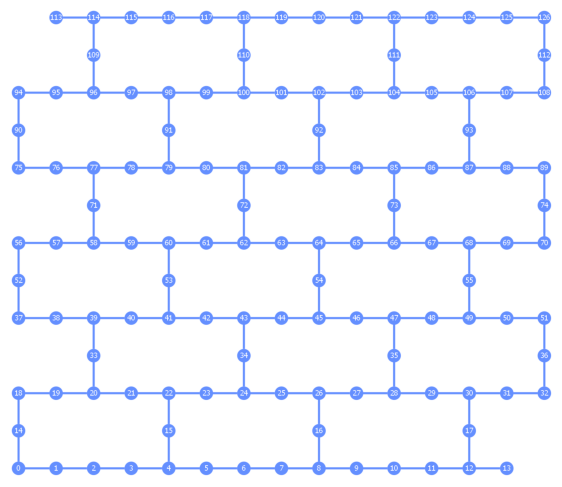

In [43]:
backend = service.backend('ibm_brisbane')
plot_gate_map(backend, figsize=(7, 7), font_size=14)

The Eagle generation of processors from IBM are arranged in a heavy-hexagonal lattice. It may not be obvious at first, but the rectangles in the layout can be thought of as hexagons. The ```FakeGuadalupe``` was actually implemented as just one of these hexagons. As with that system, Eagle processors (and subsequent generations of IBM Quantum processors) have many of the qubits connected to three nearest-neighbours, while other qubits are only connected to two. The paper published in Nature last year by the IBM Quantum team modeled a spin lattice with this same topology using an Eagle processor.

#### Exercise 3

**YOUR TASK:** Build a circuit that simulates a time step in the dynamics of a 127-site 2-D spin chain in a heavy-hexagonal lattice. The spin lattice should have the same layout as the 127-qubit Eagle processor, such as ```ibm_brisbane```. Use the same $R_{ZZ}$ gate that you created previously in this lab. The final circuit should have a 2-qubit gate depth of 3 by efficiently exploiting the qubit connectivity to execute multiple 2-qubit gates in parallel, and organized into layers. Submit your transpiled circuit, which should also have a 2-qubit gate depth of 3, to the grader.

Given that this exercise calls for using a much larger number of qubits than in the previous exercises, you are strongly advised to design an algorithmic approach to determining how to layout the 2-qubit gates in your circuit rather than manually specifying them by pairs of qubits. Otherwise, you are going to have some long lists to create manually! If you successfully provide a valid answer to the grader function for this exercise, your code may be further judged by the hackathon organizers on the originality of your approach to solving this problem and awarded additional merit. 

TIP: One possible algorithmic approach is to use graph analysis approaches. There are some good Python libraries for graph analysis, including the ```rustworkx``` library that underpins some parts of Qiskit.

In [47]:
## WRITE YOUR CODE BELOW HERE ##
layers_edges = backend.coupling_map

hex_corners = []
for row in range(6):
    for col in range(4):
        hex_corners.append(row*15+col*4-int(row>0)+4*row*int(row>0))
print(hex_corners)
print(layers_edges)

[0, 4, 8, 12, 18, 22, 26, 30, 37, 41, 45, 49, 56, 60, 64, 68, 75, 79, 83, 87, 94, 98, 102, 106]
[[1, 0], [2, 1], [3, 2], [4, 3], [4, 5], [4, 15], [6, 5], [6, 7], [7, 8], [8, 9], [10, 9], [10, 11], [11, 12], [12, 17], [13, 12], [14, 0], [14, 18], [15, 22], [16, 8], [16, 26], [17, 30], [18, 19], [20, 19], [20, 33], [21, 20], [21, 22], [22, 23], [24, 23], [24, 34], [25, 24], [26, 25], [27, 26], [28, 27], [28, 29], [28, 35], [30, 29], [30, 31], [31, 32], [32, 36], [33, 39], [34, 43], [35, 47], [36, 51], [37, 38], [39, 38], [40, 39], [40, 41], [41, 53], [42, 41], [42, 43], [43, 44], [44, 45], [46, 45], [46, 47], [48, 47], [48, 49], [50, 49], [50, 51], [52, 37], [52, 56], [53, 60], [54, 45], [54, 64], [55, 49], [55, 68], [56, 57], [57, 58], [58, 59], [58, 71], [59, 60], [60, 61], [62, 61], [62, 63], [62, 72], [63, 64], [65, 64], [65, 66], [67, 66], [67, 68], [69, 68], [69, 70], [73, 66], [74, 70], [74, 89], [75, 90], [76, 75], [77, 71], [77, 76], [77, 78], [79, 78], [79, 80], [80, 81], [81, 

In [ ]:

qc_eagle = QuantumCircuit(backend.num_qubits)
for layer in layers_edges:
    for qubits in layer:
        qc_3layer.append(RZZp2Gate,qubits)

qc_eagle_t = transpile(qc_eagle, backend, optimization_level=3)        # use this variable for your transpiled circuit to submit to the grader
# qc_eagle_t =                      # use this variable for your transpiled circuit to submit to the grader



In [ ]:
## SUBMIT TRANSPILED CIRCUIT TO GRADER
qsite24_grader_lab3ex3(qc_eagle_t, backend)

#### Run on real hardware

Now that you have a 127-qubit circuit, let's run on real hardware!

Note that this part of the lab is not graded. Use the code below to run on real hardware to see the result of all of your hard work in this lab!

First, let's start off by adding the $R_X$ gate layers and the two-qubit gate layer together, and then creating a circuit to simulate 5 time steps.

In [ ]:
time_steps = 5
qc_rx_layer = gen_rx_layer(n_qubits)
qc_eagle_5time_steps = QuantumCircuit(n_qubits)
for i in range(time_steps):
    qc_eagle_5time_steps.append(qc_rx_layer, range(n_qubits))
    qc_eagle_5time_steps.append(qc_eagle, range(n_qubits))
qc_eagle_5time_steps.decompose().draw(scale=0.1, fold=False)

Now, select one of the available 127-qubit machines from IBM Quantum. The code below selects the ```ibm_brisbane``` system, but feel free to choose another equivalent system, perhaps the one with the shortest job queue. The full circuit is then transpiled for your chosen system.

In [ ]:
backend = service.backend('ibm_brisbane')

qc_eagle_5time_steps_t = transpile(qc_eagle_5time_steps, backend)

As was done previously for the smaller 16-qubit system simulation, we'll need to use the ```EstimatorV2``` primitive. However, this time we'll use the version from the ```qiskit_ibm_runtime``` package. The code below also creates the PUBs needed, which includes one PUB for each of the three angle values for $\theta_h$ we want to simulate and the observables for a 127-qubit system.

In [ ]:
from qiskit_ibm_runtime import EstimatorV2

estimator = EstimatorV2(backend)

observables = gen_Mz_observables(n_qubits)
angles = [0.0, np.pi/4, np.pi/2]
pubs = []
for angle in angles:
    pubs.append((qc_eagle_5time_steps_t, observables, angle))

Now, run the cell below to execute on the quantum computer.

In [ ]:
job = estimator.run(pubs)
print("Job ID:", job.job_id())

It may take some time for your job to get through the job queue on the system. Check the job status using the code cell below.

In [ ]:
job.status()

Note that if you need to close this notebook for whatever reason, you may lose the ```job``` object in the process. Not to worry! You can always retrieve the results from your circuit executions from the IBM Quantum Platform later on. Use the job ID printed above or found in your workload dashboard on the IBM Quantum Platform Web site, and insert this value into the code cell below.

In [ ]:
job = service.job(<INSERT_JOB_ID_HERE>)

In [ ]:
results = job.result()

for result, angle in zip(results, angles):
    print(angle, ":", np.average(result.data.evs))

You should get a result somewhat similar to the results published in the paper mentioned at the top of this notebook (see Figure 3a in that paper). Note that error mitigation and suppression were not used. You are welcome to experiment with these features in the Qiskit Runtime with help from this [documentation](https://docs.quantum.ibm.com/guides/error-mitigation-and-suppression-techniques) to see if you can improve your results. However, note that advanced error mitigation schemes such as zero-noise extrapolation (ZNE) can require much more time to execute on the system, upwards of 8-9 minutes depending on how you configure the error mitigation settings. Keep in mind that the open plan offers up to 10 minutes of execution on real hardware per month.

### Congratulations!

You have made it to the end of this lab. Here is a summary of what you learned about Qiskit in this lab:

- Creating custom gates
- Organizing circuits into layers to improve efficiency and circuit depth
- Mapping problems to match well with the topology of quantum processors

We hope you enjoyed this challenge. All the best!